## TIMESERIES ANALYSIS

'The most difficult thing in life is to know yourself'

This quote belongs to Thales of Miletus. Thales was a Greek/Phonecian philosopher, mathematician and astronomer, which is recognised as the first individual in Western civilisation known to have entertained and engaged in scientific thought (source: https://en.wikipedia.org/wiki/Thales)

I wouldn't say that knowing your data is the most difficult thing in data science, but it is time-consuming.
We take a deeper dive into this with predicting future stock prices of the Apple Company (AAPL), based on its stock prices of the past 5 years.. <br>
### Let's start!!

In [13]:
#import necessary libraries.
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd 
from fbprophet import Prophet
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error  
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout  

In [3]:
#Read trainging data
apple_training_complete = pd.read_csv(r'AAPL (1).csv')  
df = apple_training_complete.iloc[:, 0:2]
apple_training_complete.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-12-31,72.932854,76.485718,72.714287,76.024284,53.767834,164873100
1,2013-01-02,79.117142,79.285713,77.375717,78.432854,55.471294,140129500
2,2013-01-03,78.268570,78.524284,77.285713,77.442856,54.771122,88241300
3,2013-01-04,76.709999,76.947144,75.118568,75.285713,53.245483,148583400
4,2013-01-07,74.571426,75.614288,73.599998,74.842857,52.932274,121039100


### We are only interested in the opening price of the stock. Therefore, we will filter all the data from our training set and will retain only the values for the Open column. 

In [17]:
ts =  apple_training_complete.iloc[:, 0:2]
ts.set_index('Date',inplace = True)
ts.head()


,Open
Date,
2012-12-31,72.932854
2013-01-02,79.117142
2013-01-03,78.268570
2013-01-04,76.709999
2013-01-07,74.571426


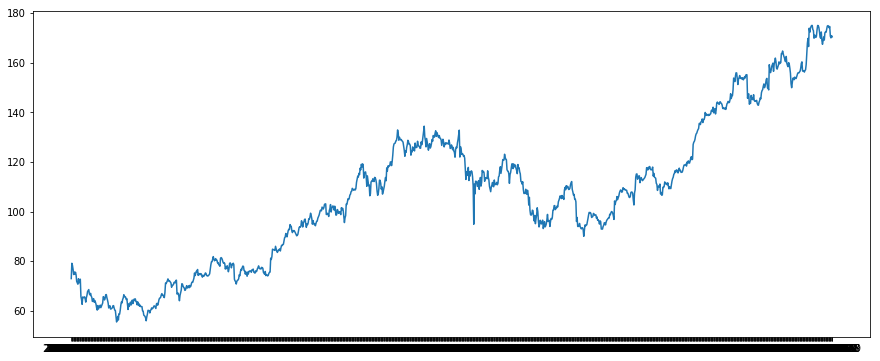

In [18]:
rcParams['figure.figsize'] = 15,6
plt.plot(ts)

### You can see that the trend is highly non-linear and it is very difficult to capture the trend using this information. This is where the power of LSTM can be utilized. LSTM (Long Short-Term Memory network) is a type of recurrent neural network capable of remembering the past information and while predicting the future values, it takes this past information into account.

---

In [6]:
#As we said earlier, we are only interested in the opening price of the stock. 
#Therefore, we will filter all the data from our training set and will retain only the values for the Open column. 
#Execute this:
apple_training_processed = apple_training_complete.iloc[:, 1:2].values  

### Data Normalization
As a rule of thumb, whenever you use a neural network, you should normalize or scale your data. We will use MinMaxScaler class from the sklear.preprocessing library to scale our data between 0 and 1. 

In [19]:
#LSTM needs scaled data. Use Scikit-learn's inbuilt API to do the job.
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler(feature_range = (0, 1))
apple_training_scaled = scaler.fit_transform(apple_training_processed)

### We have to predict a value at time T, based on the data from days T-N where N can be any number of steps. In this article, we are going to predict the opening stock price of the data based on the opening stock prices for the past 60 days. 

Our feature set should contain the opening stock price values for the past 60 days while the label or dependent variable should be the stock price at the 61st day.

In [20]:
features_set = []  
labels = []  
for i in range(60, 1260):  
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])

In the script above we create two lists: feature_set and labels. There are 1260 records in the training data. We execute a loop that starts from 61st record and stores all the previous 60 records to the feature_set list. The 61st record is stored in the labels list.

We need to convert both the feature_set and the labels list to the numpy array before we can use it for training.

In [21]:
features_set, labels = np.array(features_set), np.array(labels)  

In order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset which is 1260 in our case. The second dimension is the number of time steps which is 60 while the last dimension is the number of indicators. Since we are only using one feature, i.e Open, the number of indicators will be one.

In [22]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

We have preprocessed our data and have converted it into the desired format. now is the time to create our LSTM. The LSTM model that we are going to create will be a sequential model with multiple layers. We will add four LSTM layers to our model followed by a dense layer that predicts the future stock price.

In [24]:
#model builing-LSTM
model = Sequential()  

To add a layer to the sequential model, the add method is used. Inside the add method, we passed our LSTM layer. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The second parameter is return_sequences, which is set to true since we will add more layers to the model. The first parameter to the input_shape is the number of time steps while the last parameter is the number of indicators.

In [25]:
#Add layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  

Now add a dropout layer to our model. Dropout layer is added to avoid over-fitting, which is a phenomenon where a machine learning model performs better on the training data compared to the test data.

In [26]:
model.add(Dropout(0.2))  

Let's add three more LSTM and dropout layers to our model.

In [27]:
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2)) 

### Creating Dense Layer
To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.

In [28]:
model.add(Dense(units = 1))  

### Model Compilation
Finally, we need to compile our LSTM before we can train it on the training data. 

In [29]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error') 

We call the compile method on the Sequential model object which is "model" in our case. We use the mean squared error as loss function and to reduce the loss or to optimize the algorithm, we use the adam optimizer.

In [30]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)  

Epoch 1/100
1200/1200 [==============================] - 16s 14ms/step - loss: 0.0384
Epoch 2/100
1200/1200 [==============================] - 9s 7ms/step - loss: 0.0054
Epoch 3/100
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0048
Epoch 4/100
1200/1200 [==============================] - 9s 7ms/step - loss: 0.0043
Epoch 5/100
1200/1200 [==============================] - 9s 7ms/step - loss: 0.0046
Epoch 6/100
1200/1200 [==============================] - 9s 8ms/step - loss: 0.0039
Epoch 7/100
1200/1200 [==============================] - 10s 8ms/step - loss: 0.0035
Epoch 8/100
1200/1200 [==============================] - 9s 8ms/step - loss: 0.0048
Epoch 9/100
1200/1200 [==============================] - 9s 8ms/step - loss: 0.0044
Epoch 10/100
1200/1200 [==============================] - 9s 7ms/step - loss: 0.0036
Epoch 11/100
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0034
Epoch 12/100
1200/1200 [==============================] - 8s 7ms/step -

### Testing our LSTM
We have successfully trained our LSTM, now is the time to test the performance of our algorithm on the test set by predicting the opening stock prices for the month of January 2018. However, as we did with the training data, we need to convert our test data in the right format.

In [32]:
#Read testing data
apple_testing_complete = pd.read_csv(r'AAPL (2).csv')  
apple_testing_processed = apple_testing_complete.iloc[:, 1:2].values 

### Converting Test Data to Right Format
For each day of January 2018, we want our feature set to contain the opening stock prices for the previous 60 days. For the 1st of January, we need the stock prices for the previous 60 days. To do so, we need to concatenate our training data and test data before preprocessing.

In [33]:
#Merge the training and testing data.
apple_total = pd.concat((apple_training_complete['Open'], apple_testing_complete['Open']), axis=0)  

Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 20 test days for the month of January 2018 and the 60 stock prices from the last 60 days for the training set. Execute the following script to fetch those 80 values.

In [34]:
test_inputs = apple_total[len(apple_total) - len(apple_testing_complete) - 60:].values 

In [35]:
test_inputs = test_inputs.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)

In [36]:
test_features = []  
for i in range(60, 80):  
    test_features.append(test_inputs[i-60:i, 0])

In [37]:
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1)) 

### Making Predictions
Now is the time to see the magic. We preprocessed our test data and now we can use it to make predictions. To do so, we simply need to call the predict method on the model that we trained. 

In [38]:
#Make predictions using the model.
predictions = model.predict(test_features)  

 Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we can use the ìnverse_transform method of the scaler object we created during training. 

In [39]:
#Re-convert the data, that we had converted by scaling for analysis
predictions = scaler.inverse_transform(predictions) 

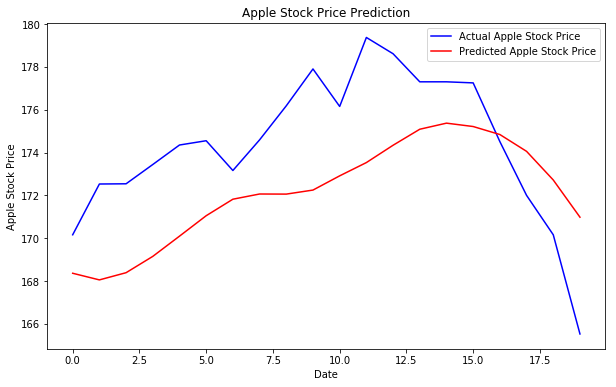

In [40]:
#Plot the results
plt.figure(figsize=(10,6))  
plt.plot(apple_testing_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()

In the output, the blue line represents the actual stock prices for the month of January 2018, while the red line represents the predicted stock prices. You can clearly see that our algorithm has been able to capture the overall trend. The predicted prices also see a bullish trend at the beginning followed by a bearish or downwards trend at the end. <br>
A long short-term memory network (LSTM) is one of the most commonly used neural networks for time series analysis. The ability of LSTM to remember previous information makes it ideal for such tasks.

---

# PROPHET

### BUILDING THE PROPHET MODEL 
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

We use a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

#####  y(t)=g(t)+s(t)+h(t)+εt

 

In [5]:
#Viewing data.
df.head()

,Date,Open
0,2012-12-31,72.932854
1,2013-01-02,79.117142
2,2013-01-03,78.268570
3,2013-01-04,76.709999
4,2013-01-07,74.571426


### Note: In prophet model the dataframe columns must be named compulsorily as ds(date column) and y(output column)

In [6]:
#Renaming the columns.
df.columns = ['ds','y']
df['ds']=pd.to_datetime(df['ds'])


### Seasonalities that depend on other factors(Try yourself)
In some instances the seasonality may depend on other factors, such as a weekly seasonal pattern that is different during the summer than it is during the rest of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays. These types of seasonalities can be modeled using conditional seasonalities.

The default weekly seasonality assumes that the pattern of weekly seasonality is the same throughout the year, but we’d expect the pattern of weekly seasonality to be different during the on-season (when there are HOLIDAYS every Sunday) and the off-season. We can use conditional seasonalities to construct separate on-season and off-season weekly seasonalities.

---

### Additional regressors
Additional regressors can be added to the linear part of the model using the add_regressor method or function. A column with the regressor value will need to be present in both the fitting and prediction dataframes. For example, we can add an additional effect on Sundays during the NFL season. 

In [7]:
#First we add a boolean column to the dataframe that indicates whether each date is during the on-season or the off-s
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

In [ ]:
#Diving the dataset into train and test:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size,:] , df.iloc[train_size:len(df),:]

### We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor.

In [ ]:
#Modelling Prophet
model = Prophet(changepoint_range=0.9,daily_seasonality=True,yearly_seasonality=True, weekly_seasonality=False )

### Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method (Python)

### The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

In [ ]:
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=70)

### Built-in Country Holidays
You can use a built-in collection of country-specific holidays using the add_country_holidays method (Python) or function (R). The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the holidays argument described above:

In [ ]:
model.add_country_holidays(country_name='US')

In [ ]:
model.add_regressor('nfl_sunday')

### Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [ ]:
model.fit(train)

### You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [ ]:
futureVals = model.make_future_dataframe(periods =test_size+130)

In [ ]:
#Adding the above regressor.
futureVals['nfl_sunday'] = futureVals['ds'].apply(nfl_sunday)

### The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The predictedVals object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [ ]:
predictedVals = model.predict(futureVals)

## Post processing

C:\Users\Ganesh\Anaconda4\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


321.40318170309985


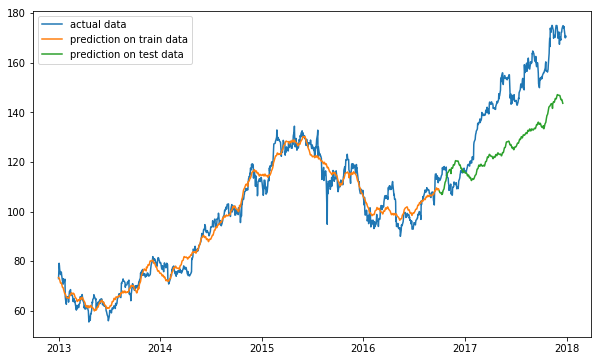

In [26]:
#Finding RMSE and Plotting for actual vs predicted data. 
print(mean_squared_error(test['y'],predictedVals.yhat.iloc[-test_size:]))
plt.figure(figsize=(10,6))  
plt.plot(df.ds,df.y,label="actual data")
plt.plot(predictedVals.iloc[0:train_size,:].ds,predictedVals.iloc[0:train_size,:].yhat,label="prediction on train data")
plt.plot(predictedVals.iloc[train_size:,:].ds,predictedVals.iloc[train_size:,:].yhat,label="prediction on test data")
plt.legend()
plt.show()

### We see that Prophet model fits almost well with some parameter tuning, with some more tweaks in parameeter might lead to even better fit.